In [2]:
import pandas as pd
import sys
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

dataset used is spam email dataset from the HP Lab to predict if an email is spam. The dataset contains 4601 email items, of which 1813 items were identified as spam

#### For starters, moving on without feature engineering

### The dataset contains the following features:
#### crl.tot
total length of words in capitals

#### dollar
number of occurrences of the \$ symbol

#### bang
number of occurrences of the ! symbol

#### money
number of occurrences of the word ‘money’

#### n000
number of occurrences of the string ‘000’

#### make
number of occurrences of the word ‘make’

#### yesno
outcome variable, a factor with levels n not spam, y spam

### Importing dataset and summary statistic

In [3]:
ds=pd.read_csv('https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/DAAG/spam7.csv')
ds['spam'] = ds['yesno'].map({'y': 1, 'n': 0})
ds = ds.drop(['Unnamed: 0','yesno',], axis=1)

ds.head()

,crl.tot,dollar,bang,money,n000,make,spam
0,278,0.000,0.778,0.00,0.00,0.00,1
1,1028,0.180,0.372,0.43,0.43,0.21,1
2,2259,0.184,0.276,0.06,1.16,0.06,1
3,191,0.000,0.137,0.00,0.00,0.00,1
4,191,0.000,0.135,0.00,0.00,0.00,1


In [4]:
ds.mean()

crl.tot    283.289285
dollar       0.075811
bang         0.269071
money        0.094269
n000         0.101645
make         0.104553
spam         0.394045
dtype: float64

The descriptive statistics below give a first idea on which features are correlated with spam emails. Everything related to money (dollar, money, n000) is strongly correlated with spam. Spammers use more words in capitals and the word "make" as well as exclamation points more frequently.

In [5]:
ds.groupby(['spam']).mean()

,crl.tot,dollar,bang,money,n000,make
spam,,,,,,
0,161.470947,0.011648,0.109984,0.017138,0.007088,0.073479
1,470.619415,0.174478,0.513713,0.212879,0.247055,0.152339


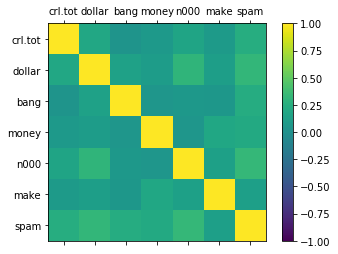

,crl.tot,dollar,bang,money,n000,make,spam
crl.tot,1.000000,0.201948,0.036321,0.080993,0.165977,0.089165,0.249164
dollar,0.201948,1.000000,0.142913,0.104691,0.310971,0.117419,0.323629
bang,0.036321,0.142913,1.000000,0.051076,0.070103,0.058292,0.241888
money,0.080993,0.104691,0.051076,1.000000,0.052587,0.188155,0.216111
n000,0.165977,0.310971,0.070103,0.052587,1.000000,0.134072,0.334787
make,0.089165,0.117419,0.058292,0.188155,0.134072,1.000000,0.126208
spam,0.249164,0.323629,0.241888,0.216111,0.334787,0.126208,1.000000


In [6]:
correlations = ds.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
names = ['']+list(ds)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()
correlations

### Set Y and X space, generate interaction terms, split dataset in train and test
We expand the feature space by creating interaction terms. (Patsy is a great scikit-learn tool to create many interaction terms with one line of code)

In [8]:
y =ds.spam
df= ds.loc[:, ds.columns != 'spam']

In [10]:
#add features by generating interaction terms
dollar_bang=df['dollar']*df['bang']
dollar_money=df['dollar']*df['money']
dollar_n000=df['dollar']*df['n000']
dollar_make=df['dollar']*df['make']
dollar_crl=df['dollar']*df['crl.tot']

bang_money=df['bang']*df['money']
bang_n000=df['bang']*df['n000']
bang_make=df['bang']*df['make']
bang_crl=df['bang']*df['crl.tot']

money_n000=df['money']*df['n000']
money_make=df['money']*df['make']
money_crl=df['money']*df['crl.tot']

n000_make=df['n000']*df['make']
n000_crl=df['n000']*df['crl.tot']

make_crl=df['make']*df['crl.tot']


df=df.assign(dollar_bank=dollar_bang,dollar_money=dollar_money,dollar_n000=dollar_n000,dollar_make=dollar_make,dollar_crl=dollar_crl,bang_money=bang_money, bang_n000=bang_n000,bang_make=bang_make,bang_crl=bang_crl,money_n000=money_n000,money_make=money_make,money_crl=money_crl,n000_make=n000_make,n000_crl=n000_crl,make_crl=make_crl)       

df.head()

,crl.tot,dollar,bang,money,n000,make,bang_crl,bang_make,bang_money,bang_n000,...,dollar_crl,dollar_make,dollar_money,dollar_n000,make_crl,money_crl,money_make,money_n000,n000_crl,n000_make
0,278,0.000,0.778,0.00,0.00,0.00,216.284,0.00000,0.00000,0.00000,...,0.000,0.00000,0.00000,0.00000,0.00,0.00,0.0000,0.0000,0.00,0.0000
1,1028,0.180,0.372,0.43,0.43,0.21,382.416,0.07812,0.15996,0.15996,...,185.040,0.03780,0.07740,0.07740,215.88,442.04,0.0903,0.1849,442.04,0.0903
2,2259,0.184,0.276,0.06,1.16,0.06,623.484,0.01656,0.01656,0.32016,...,415.656,0.01104,0.01104,0.21344,135.54,135.54,0.0036,0.0696,2620.44,0.0696
3,191,0.000,0.137,0.00,0.00,0.00,26.167,0.00000,0.00000,0.00000,...,0.000,0.00000,0.00000,0.00000,0.00,0.00,0.0000,0.0000,0.00,0.0000
4,191,0.000,0.135,0.00,0.00,0.00,25.785,0.00000,0.00000,0.00000,...,0.000,0.00000,0.00000,0.00000,0.00,0.00,0.0000,0.0000,0.00,0.0000


#### Split dataset into train and test set.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2)

### Run a baseline model without tuning

I use the following baseline scikit-learn library settings.

#### Tree specific parameters
n_estimators=100 (number of trees)  
max_depth=3  
min_samples_split=2  
min_samples_leaf=1  
subsample=1.0  

#### Other Parameters
learning_rate=0.1 (shrinkage)  
subsample: 1


Accuracy of the GBM on test set: 0.872
             precision    recall  f1-score   support

          0       0.86      0.95      0.90       569
          1       0.91      0.74      0.82       352

avg / total       0.88      0.87      0.87       921



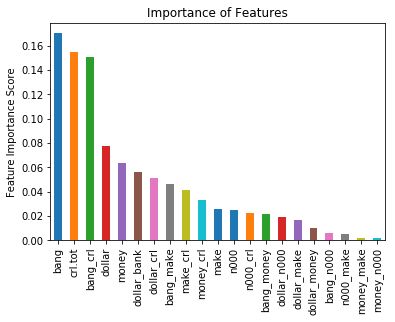

In [15]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.grid_search import GridSearchCV

baseline = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 100, max_depth = 3, min_samples_split = 2, min_samples_leaf = 1, subsample = 1, max_features = 'sqrt', random_state=10)
baseline.fit(X_train,y_train)
predictors=list(X_train)
feat_imp = pd.Series(baseline.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on test set: {:.3f}'.format(baseline.score(X_test, y_test)))
pred=baseline.predict(X_test)
print(classification_report(y_test, pred))
plt.show()

The plot displays the importance of the feature: The number of words in capital and bang seem to have the highest predictive power.

With this first model, we obtain a rate of 0.90 of true positives (positive meaning spam) and 0.87 true negatives and an accuracy of 0.88.


### Tuning parameters

Many strategies exist on how to tune parameters. See for example this blog post on Machine Learning Mastery for some guidance from academic papers. Most data scientist see number of trees, tree depth and the learning rate as most crucial parameters.

Hence, we will start off with these three and then move to other tree-specific parameters and the subsamples. I will use 5-fold cross validation and evaluate models based on accuracy. You may also consider to evaluate the model based on a different measure such as roc_auc.

#### Tunign n_estimators and Learning rate

n_estimators captures the number of trees that we add to the model. A high number of trees can be computationally expensive. Generally, with a change in learning rate,n_estimators should also be adjusted (10-fold decrease in learning_rate should go in line with a approx. 10-fold increase in n_estimators.


In [16]:
p_test3 = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001], 'n_estimators':[100,250,500,750,1000,1250,1500,1750]}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10), 
            param_grid = p_test3, scoring='accuracy',n_jobs=4,iid=False, cv=5)
tuning.fit(X_train,y_train)
tuning.grid_scores_, tuning.best_params_, tuning.best_score_

([mean: 0.88125, std: 0.00872, params: {'learning_rate': 0.15, 'n_estimators': 100},
  mean: 0.87907, std: 0.00972, params: {'learning_rate': 0.15, 'n_estimators': 250},
  mean: 0.87690, std: 0.00983, params: {'learning_rate': 0.15, 'n_estimators': 500},
  mean: 0.87554, std: 0.00951, params: {'learning_rate': 0.15, 'n_estimators': 750},
  mean: 0.87255, std: 0.00780, params: {'learning_rate': 0.15, 'n_estimators': 1000},
  mean: 0.87065, std: 0.00726, params: {'learning_rate': 0.15, 'n_estimators': 1250},
  mean: 0.86848, std: 0.00724, params: {'learning_rate': 0.15, 'n_estimators': 1500},
  mean: 0.86984, std: 0.00697, params: {'learning_rate': 0.15, 'n_estimators': 1750},
  mean: 0.88287, std: 0.01440, params: {'learning_rate': 0.1, 'n_estimators': 100},
  mean: 0.88315, std: 0.01118, params: {'learning_rate': 0.1, 'n_estimators': 250},
  mean: 0.88260, std: 0.00901, params: {'learning_rate': 0.1, 'n_estimators': 500},
  mean: 0.87744, std: 0.00972, params: {'learning_rate': 0.1, 'n


### max_depth

max_depth bounds the maximum depth of the tree. We can use the obtained results to tune the max_depth parameter. There is one interesting comment on depth in the scikit-learn documentation especially relevant for large datasets: "We found that max_leaf_nodes=k gives comparable results to max_depth=k-1 but is significantly faster to train at the expense of a slightly higher training error."


In [18]:
p_test2 = {'max_depth':[2,3,4,5,6,7] }
tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.01,n_estimators=1500, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10), 
            param_grid = p_test2, scoring='accuracy',n_jobs=4,iid=False, cv=5)
tuning.fit(X_train,y_train)
tuning.grid_scores_, tuning.best_params_, tuning.best_score_

([mean: 0.88287, std: 0.01231, params: {'max_depth': 2},
  mean: 0.88260, std: 0.01500, params: {'max_depth': 3},
  mean: 0.88260, std: 0.01440, params: {'max_depth': 4},
  mean: 0.88070, std: 0.01542, params: {'max_depth': 5},
  mean: 0.88260, std: 0.01169, params: {'max_depth': 6},
  mean: 0.88532, std: 0.01080, params: {'max_depth': 7}],
 {'max_depth': 7},
 0.8853212044359955)

### First evaluation of new model on test set

The model's performance did improve with the tuning. The "true positive" and the "true negative" rate improved. Interestingly, there was also a slight change in the ranking of feature importance with the interaction of bang and crl_tot now ranked first.


Accuracy of the GBM on test set: 0.876
             precision    recall  f1-score   support

          0       0.86      0.95      0.90       569
          1       0.90      0.76      0.82       352

avg / total       0.88      0.88      0.87       921



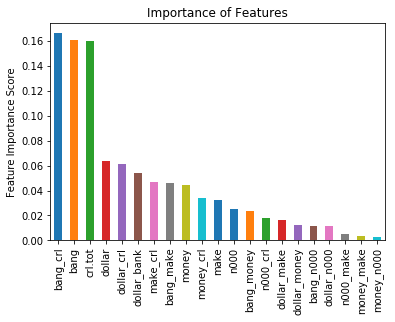

In [21]:
model1 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=1500,max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)
model1.fit(X_train,y_train)
predictors=list(X_train)
feat_imp = pd.Series(model1.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on test set: {:.3f}'.format(model1.score(X_test, y_test)))
pred=model1.predict(X_test)
print(classification_report(y_test, pred))
plt.show()

### Other factors

#### Tree related parameters: Min sample split and min samples leaf

min_samples_split sets the minimum number of samples to split while min_samples_leaf sets the minimum number of samples to form a leaf (Notice the slight difference).
